# Project: Marketing Email Campaign---Is there any way to improve click through rate in email marketing campaigns?

## Key Words: Segment users, XGBoost, Roc curve, Probability threshold, Classification Report, Precision Score, Recall Score

## Background:
Optimizing marketing campaigns is one of the most common data science tasks. In this project, the marketing team of an e-commerce site has launched an email campgain. They chosen a random sample of users and emailed them. The email let the user know that the company will launch a new feature. From the marketing team perspective, a success is if the user clicks on the link inside the email. I will study if the click through rate can be improved. During this process, I will sovle the following questions: 

**Question 1:** What percentage of uses opened the email and what percentage clicked on the link within the email?

**Question 2:** For different segments of users, is there any pattern on how the email campaign performed?

**Question 3:** Can a model be build to maximize the probability of users clicking on the link inside the email insteading of sending email randomly? How much the model can improve the click through rate?

**Question 4:** How to test if the model can improve click through rate?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score

import xgboost as xgb

%matplotlib inline
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Table of Contents
  1. [Preparing Data](#preparing)
  2. [Question 1](#question1)
  3. [Explore Pattern for different segments of users](#explorepattern)  
  [Country vs. Customers'reactions](#country)  
  [Email personalized vs. Customers' reactions](#emailpersonalized)  
  [Country vs. Personalized vs. Customers' reactions](#countrypersonalized)
  [Purchase history vs. Customers' reactions](#purchasehistory)  
  [Weekday vs. Customers' reactions](#weekday)  
  [Country vs. Weekday vs. Customers' reactions](#countryweekday)  
  [Email length vs. Customers'reaction](#emaillength)  
  [Country vs. Email Length vs. Customers' reactions](#countrylength) 
  4. [Question 2](#question2)
  5. [Build Predictive Model](#build)  
  [Prepare the data](#prepare)  
  [Train the model](#train)  
  [Plot ROC curve and choose probability threshold](#plot)
  6. [Question 3](#question3)
  7. [Question 4](#question4)

<a id='preparing'></a>
## Preparing Data

In [4]:
# read the email table and corresponding describe and statistical information
email = pd.read_csv('C:/Users/xiaoj/Desktop/level 20 interview/email/email_table.csv',index_col = 'email_id')
email.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [338]:
# rename long column names to shorter and understandable ones to make it easier to manipulation
email.rename(columns = {'email_id':'id', 'email_text':'is_short', 'email_version':'is_personalized','user_country':'country', 'user_past_purchases':'purchases'},inplace=True)
email.head()

,is_short,is_personalized,hour,weekday,country,purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [8]:
email.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 85120 to 348333
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   is_short         100000 non-null  object
 1   is_personalized  100000 non-null  object
 2   hour             100000 non-null  int64 
 3   weekday          100000 non-null  object
 4   country          100000 non-null  object
 5   purchases        100000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


From the data information, it can be easily found that there are 6 features, two of which are numerical and the others are categorical. So I will firstly check the statistical information and types, respectively。

In [9]:
# Check the numerical features
email.describe()

,hour,purchases
count,100000.000000,100000.00000
mean,9.059300,3.87845
std,4.439637,3.19611
min,1.000000,0.00000
25%,6.000000,1.00000
50%,9.000000,3.00000
75%,12.000000,6.00000
max,24.000000,22.00000


In [11]:
#check the categories in categorical features
[email[x].nunique() for x in ['is_short','is_personalized','weekday','country']]

[2, 2, 7, 4]

In [5]:
# read the data in another two tables
open = pd.read_csv('C:/Users/xiaoj/Desktop/level 20 interview/email/email_opened_table.csv')
open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [6]:
click = pd.read_csv('C:/Users/xiaoj/Desktop/level 20 interview/email/link_clicked_table.csv')
click.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


I added a new feature in 'email' called 'reaction', which showed the customer's reactions to the link after they received the email.

In [339]:
# add a new feature
email['reaction'] = 'received'

# according to the other two tables, specify the operations customers did 
email.loc[open['email_id'],'reaction'] = 'opened'
email.loc[click['email_id'],'reaction'] = 'clicked'

email.head()

,is_short,is_personalized,hour,weekday,country,purchases,reaction
email_id,,,,,,,
85120,short_email,personalized,2,Sunday,US,5,received
966622,long_email,personalized,12,Sunday,UK,2,clicked
777221,long_email,personalized,11,Wednesday,US,2,received
493711,short_email,generic,6,Monday,UK,1,received
106887,long_email,generic,14,Monday,US,6,received


<a id='question1'></a>
## Question 1
What percentage of users opened the email and what percentage clicked on the link within the email?

In [17]:
reaction = email['reaction'].value_counts(normalize = True)
reaction

received    0.89605
opened      0.08276
clicked     0.02119
Name: reaction, dtype: float64

It can be easily found that 10.39 %(opened + clicked)customers opened the email, and 2.12 % customers clicked the link.

In [19]:
print("{:.2f}% of users opened the email.".format((1 - reaction.received) * 100))
print("{:.2f}% of users clicked the link.".format(reaction.clicked * 100))

10.39% of users opened the email.
2.12% of users clicked the link.


In [23]:
final_counts = email['reaction'].value_counts(normalize = True)
final_counts['total'] = email.shape[0]
final_counts.head()

received         0.89605
opened           0.08276
clicked          0.02119
total       100000.00000
Name: reaction, dtype: float64

<a id='explorepattern'></a>
## Explore Pattern for different segments of user 

<a id='chi2'></a>
### Chi2-test
Chi-square test can be performed to compare features, and find which are more important and related to the customers' reaction.

In [201]:
# make a copy of the table and do Chi2-test
X = email.copy()

# labelencoder the categorical fields inside the table
X['reaction'] = LabelEncoder().fit_transform(X['reaction'])
X['is_short'] = LabelEncoder().fit_transform(X['is_short'])
X['weekday'] = LabelEncoder().fit_transform(X['weekday'])
X['is_personalized'] = LabelEncoder().fit_transform(X['is_personalized'])
X['country'] = LabelEncoder().fit_transform(X['country'])

# define the x and y for the chi2-test
x = X.drop(columns='reaction')
y = X['reaction']

# chi2-test
chi2score,pvalue = chi2(x,y)
feature_chiscore = pd.DataFrame({'chi2score':chi2score},index = X.drop(columns='reaction').columns)
feature_chiscore.sort_values(by='chi2score',ascending=False)

,chi2score
purchases,3448.795660
country,378.554465
is_personalized,316.752872
weekday,234.405864
hour,147.815921
is_short,81.527600


From the **chi2** test, it can be fount that:
- The most three important features that influence the customers' click rate is **purchases**(that is to say the customers' previous purchase experiences), **country**, **is_personalized**(if email is personalized);


- The less features are weekday,hour and email length;

Then I will explore the pattern on how the email campaign performed for different segment of users.

In [214]:
# define functions that can be generally applied to the various features when chek their influence on click rate
def final_ratio(data):
    final_counts = data['reaction'].value_counts(normalize = True)
    return final_counts

def feature_plot(feature):
    feature_inf = email.groupby(feature).apply(final_ratio)
    feature_inf.loc[:,['opened','clicked']].plot(kind='bar')
    plt.ylabel('Click Ratio')
    plt.xlabel(feature)
    plt.xticks(rotation=0)
    plt.title('Click Ratio vs. {}'.format(feature))
    return feature_inf.sort_values(by=['clicked'],ascending = False)

<a id='country'></a>
### Country vs. Customers' reactions

reaction,received,opened,clicked
country,,,
UK,0.879282,0.096043,0.024675
US,0.880481,0.095160,0.024360
ES,0.960570,0.031103,0.008327
FR,0.958779,0.033217,0.008004


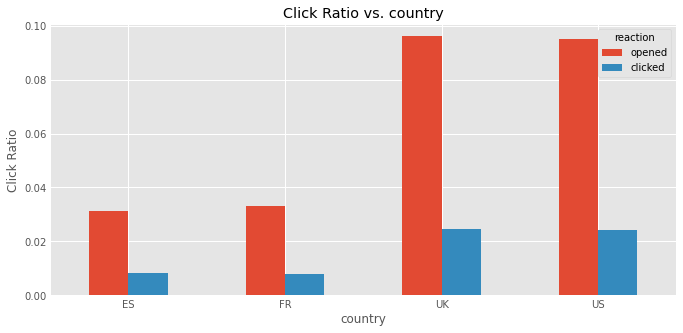

In [215]:
# check if country has influence on click rate
feature_plot('country')

It can be easily found that both 'open' and 'click' percentage are much higher in UK and US than in France and Spain. 

This may be the translation issue. For English-speaking counties, the web are easier to understand. While for those non-English-speaking countries, the emails sent out are not as easy as native language to be readable, which cause low open and click percentages. 

<a id='emailpersonalized'></a>
### Email personalized vs. Customers' reactions

reaction,received,opened,clicked
is_personalized,,,
personalized,0.871864,0.100842,0.027294
generic,0.920034,0.064829,0.015137


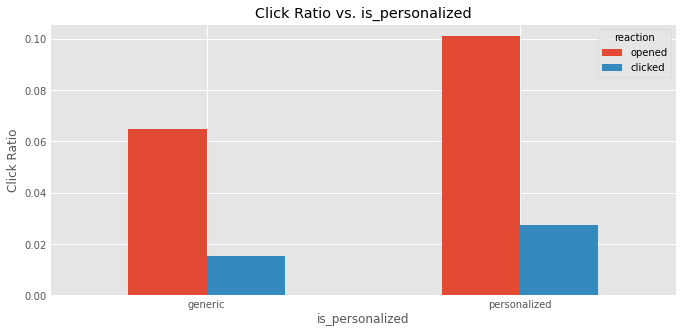

In [216]:
# check if personlized email will produce more click rate
feature_plot('is_personalized')

It is easily to understand that personalized emails are more easier to be opened and clicked.

<a id='countrypersonalized'></a>
### Country vs. Personalized vs. Customers' reactions

In [210]:
country_personalized = email.groupby(['country',"is_personalized"]).apply(final_ratio).unstack()
country_personalized_click = country_week.loc[:,'clicked']
country_personalized_click['per/gen']=round(country_personalized_click['personalized']/country_personalized_click['generic'],2)
country_personalized_click.sort_values(by='per/gen',ascending = False)

<ipython-input-210-7441a1905106>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_personalized_click['per/gen']=round(country_personalized_click['personalized']/country_personalized_click['generic'],2)


is_personalized,generic,personalized,per/gen
country,,,
FR,0.005365,0.010681,1.99
ES,0.005626,0.011022,1.96
US,0.017299,0.031507,1.82
UK,0.018262,0.031084,1.70


The French and Spain prefered the personalized emails, especially the French showed the highest click-through-rate after opened the personalized email. People in US and UK didn't care this as much as french and spain did. But, personalized email do have better effect on click-through-rate in all countries.

<a id='purchasehistory'></a>
### Purchase history vs. Customers' reactions

Text(0, 0.5, 'ratio')

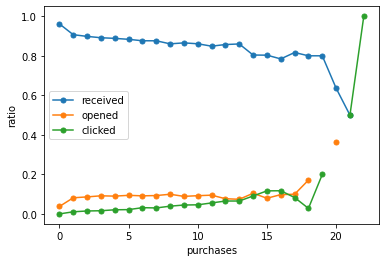

In [114]:
# check how users'past purchases influence the final click rate
purchase_inf = email.groupby("purchases").apply(final_ratio).unstack()
#purchase_inf.fillna(value=0,inplace=True)

purchase_inf.loc[:,["received","opened",'clicked']].plot(marker='o',markersize=5)
plt.ylabel("ratio")

It can be found that although some of the data after customers have purchased many times are missing, the total trend is obvious.The more items a user purchased previously, the more likely that the user will open the email and further click the link. 

<a id='weekday'></a>
### Weekday vs. Customers' reactions

reaction,received,opened,clicked
weekday,,,
Wednesday,0.879296,0.093084,0.027620
Tuesday,0.879092,0.096019,0.024889
Thursday,0.881348,0.094207,0.024445
Monday,0.883590,0.093504,0.022906
Saturday,0.912005,0.070149,0.017846
Sunday,0.911448,0.071801,0.016751
Friday,0.925019,0.060944,0.014037


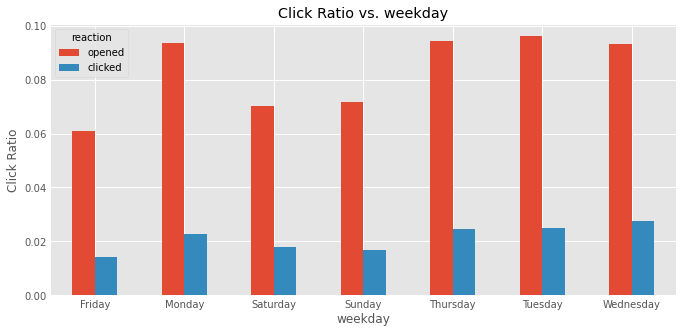

In [217]:
# check if weekday has relationship with click rate
feature_plot('weekday')

It can be found from above figure that Fiday, Satuday, Sunday have obviously lower 'open' and 'click' percentage than the other days. 

<a id='countryweekday'></a>
### Country vs. Weekday vs. Customers' reactions

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

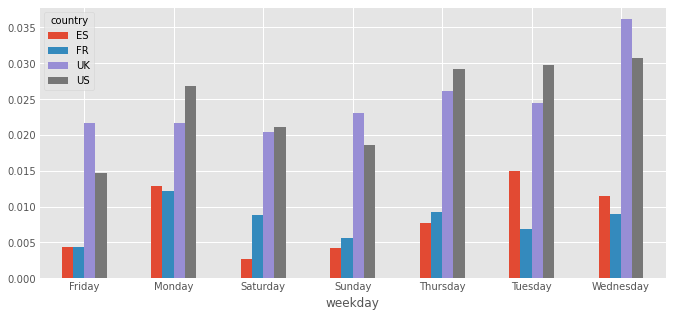

In [220]:
country_week = email.groupby(['country',"weekday"]).apply(final_ratio).unstack()
country_week = country_week.loc[:,'clicked']

country_week.T.plot(kind='bar')
plt.xticks(rotation=0)

After segmenting the customers by country, it can be found that basically all countries showed lowest click-through-rate from Friday to Sunday. But for different countrires the specific lowest and highest click rate occurred on different days.

<a id='sendinghour'></a>
### Sending hour vs. Customers' reactions

Text(0, 0.5, 'ratio')

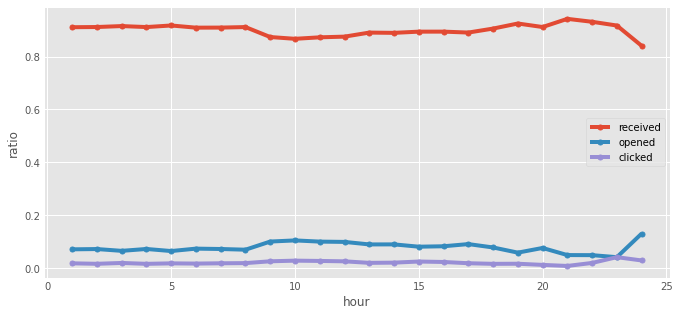

In [169]:
# check if sending time has relationship with click rate
plt.rc('figure', figsize=(10, 5))
hour_inf = email.groupby("hour").apply(final_ratio).unstack()
hour_inf.loc[:,["received","opened",'clicked']].plot(marker='o',markersize=5)
plt.ylabel("ratio")

It can be found that sending hour has some impact on the click through rate after 10.00p.m.. 

<a id='countrysendinghour'></a>
### Country vs. Sending hour vs. Customers' reactions

Text(0, 0.5, 'ratio')

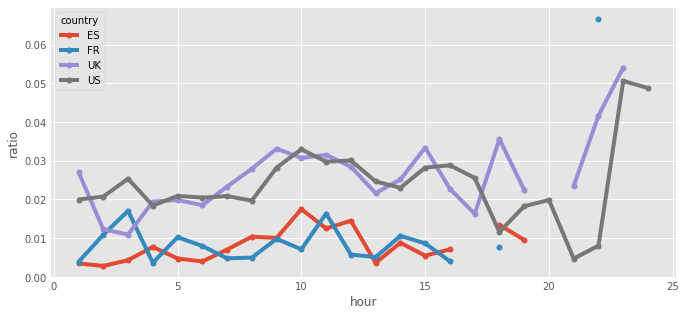

In [173]:
# check if sending time has relationship with click rate
country_hour = email.groupby(['country',"hour"]).apply(final_ratio).unstack()
country_hour.loc[:,'clicked'].unstack().T.plot(kind='line',marker='o',markersize=5)
plt.ylabel("ratio")

After segmenting users by country, it is easily to find that actually the open and click data after 10:00 p. m.are missing. So, the values we observed in the previous "Sending hour vs. Customers' reactions" are averged from received, open and click. The fact is that there are no data to show how the click rate changed. Based on the chi2 test results,the 'hour' feature will not be included in the later model. 

<a id='emaillength'></a>
### Email length vs. Customers' reaction

reaction,received,opened,clicked,click:open
is_short,,,,
short_email,0.883698,0.092430,0.023872,0.21
long_email,0.908266,0.073196,0.018538,0.20


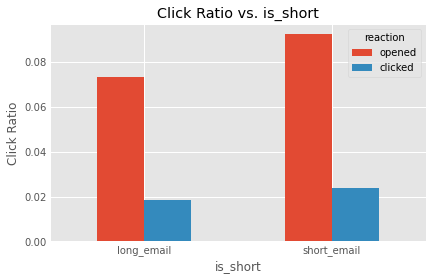

In [126]:
# check if 'email text' is short has influence on final click rate
feature_plot('is_short')

It can be found that if without considering other factors, short emails do lead to higher click through rate.

<a id='countrylength'></a>
### Country vs. Email Length vs. Customers' reactions

In [229]:
country_length = email.groupby(['country','is_short'])['reaction'].value_counts(normalize = True).unstack()
country_length = country_length.loc[:,'clicked'].unstack()
country_length['short/long'] = round(country_length['short_email'] / country_length['long_email'], 2)
country_length.sort_values(by='short/long', ascending = False)

is_short,long_email,short_email,short/long
country,,,
FR,0.006380,0.009640,1.51
UK,0.021277,0.028135,1.32
US,0.021274,0.027481,1.29
ES,0.008638,0.008018,0.93


After segmenting the customers by country, it can be found that the French like the short email than other countries. The click rate of short emails are about 1.5 times higher than that of long emails. However, from the previous chi2 test, we know the the email length is one of the least important features, which means the the effect of email lenghth can be ignored.

<a id='question2'></a>
## Question 2
For different segments of users, is there any pattern on how the email campaign performed?

- The more items people bought in the past, the more likely that users will click the link inside the email;


- UK and US has obviously higher click rates compared to the other two countries;


- People prefer short emails which induce higher click rate. People prefer simple and shorter sensences to save their time and energy;


- Personliazed email do has great infulence on click-through-rate. The French and Spain especially care about this than the people in US and UK;


- Emails sent at weekend(Friday, Saturday and Sunday) are less likely to be opened and clicked;

<a id='build'></a>
## Build Predictive Model
Build a model to predict whether a user will open the email and click the link inside it. Then try to maximize the probability of users clicking on the link by using this model.

<a id='prepare'></a>
### Prepare the data

In [497]:
# cope the originial data and create a new one
z = email.copy()
z.head()

,is_short,is_personalized,hour,weekday,country,purchases,reaction
email_id,,,,,,,
85120,short_email,personalized,2,Sunday,US,5,received
966622,long_email,personalized,12,Sunday,UK,2,clicked
777221,long_email,personalized,11,Wednesday,US,2,received
493711,short_email,generic,6,Monday,UK,1,received
106887,long_email,generic,14,Monday,US,6,received


In [498]:
# labelencoder the categorical fields inside the table
z['is_short'] = LabelEncoder().fit_transform(z['is_short'])
z['is_personalized'] = LabelEncoder().fit_transform(z['is_personalized'])

# to category if weekend or not
z['weekday'] = LabelEncoder().fit_transform(z['weekday'])
z['weekday'] = (z['weekday']>=4).astype(int)

z = pd.get_dummies(z,columns=['country'])


# define the x and y 
x = z.drop(columns=['reaction','hour'])
y = (email['reaction']=='clicked').astype(int)

In [499]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.33, random_state=42,stratify=y)
print('Train positive ratio={:.3f}'.format(ytrain1.mean()))
print('Test positive ratio={:.3f}'.format(ytest1.mean()))

Train positive ratio=0.021
Test positive ratio=0.021


From the above results, it can be found it's an imbalanced data.

<a id='train'></a>
### Train the model

In [500]:
train_matrix = xgb.DMatrix(xtrain, ytrain)
test_matrix = xgb.DMatrix(xtest)

In [501]:
params = {'eta':0.1,
          'subsample':0.8,
          'max_depth':6,
          'colsample_bytree':0.8,
          'scale_pos_weight':7,
          'objective':'binary:logistic',
          'eval_metric':'auc'}
cv_result=xgb.cv(params, 
       train_matrix, 
       num_boost_round=300, 
       nfold=5, 
       early_stopping_rounds=30, 
       seed=42,
       verbose_eval=True)

[0]	train-auc:0.73698+0.00196	test-auc:0.71653+0.00950
[1]	train-auc:0.74254+0.00209	test-auc:0.72315+0.01189
[2]	train-auc:0.74636+0.00184	test-auc:0.72561+0.01183
[3]	train-auc:0.74846+0.00192	test-auc:0.72843+0.01159
[4]	train-auc:0.74986+0.00388	test-auc:0.73099+0.00887
[5]	train-auc:0.75051+0.00456	test-auc:0.73146+0.00874
[6]	train-auc:0.75072+0.00633	test-auc:0.73066+0.00694
[7]	train-auc:0.75240+0.00400	test-auc:0.73135+0.00871
[8]	train-auc:0.75355+0.00310	test-auc:0.73273+0.00851
[9]	train-auc:0.75405+0.00287	test-auc:0.73270+0.00833
[10]	train-auc:0.75409+0.00229	test-auc:0.73238+0.00837
[11]	train-auc:0.75442+0.00154	test-auc:0.73274+0.00871
[12]	train-auc:0.75484+0.00189	test-auc:0.73318+0.00827
[13]	train-auc:0.75566+0.00181	test-auc:0.73423+0.00828
[14]	train-auc:0.75554+0.00189	test-auc:0.73368+0.00841
[15]	train-auc:0.75596+0.00170	test-auc:0.73405+0.00852
[16]	train-auc:0.75590+0.00159	test-auc:0.73379+0.00907
[17]	train-auc:0.75633+0.00168	test-auc:0.73431+0.00879
[1

In [502]:
n_best_trees = cv_result.shape[0]
n_best_trees

31

In [503]:
watchlist=[(train_matrix,'train')]
gbt = xgb.train(params,train_matrix,cv_result.shape[0],watchlist)

[0]	train-auc:0.73300
[1]	train-auc:0.73916
[2]	train-auc:0.74269
[3]	train-auc:0.74555
[4]	train-auc:0.74762
[5]	train-auc:0.74856
[6]	train-auc:0.74931
[7]	train-auc:0.74966
[8]	train-auc:0.75019
[9]	train-auc:0.75175
[10]	train-auc:0.75154
[11]	train-auc:0.75175
[12]	train-auc:0.75210
[13]	train-auc:0.75227
[14]	train-auc:0.75215
[15]	train-auc:0.75272
[16]	train-auc:0.75311
[17]	train-auc:0.75347
[18]	train-auc:0.75363
[19]	train-auc:0.75368
[20]	train-auc:0.75368
[21]	train-auc:0.75381
[22]	train-auc:0.75402
[23]	train-auc:0.75392
[24]	train-auc:0.75413
[25]	train-auc:0.75436
[26]	train-auc:0.75465
[27]	train-auc:0.75438
[28]	train-auc:0.75444
[29]	train-auc:0.75440
[30]	train-auc:0.75460


<a id='plot'></a>
### Plot ROC curve and choose probability threshold
Since the data is highly imbalanced,if using default probability threshold(0.5), the model will classify every example as negative. So a better probability threshold should be chosen.

In [504]:
print ("n_best_trees={},xgboost parameters: ".format(n_best_trees))
params

n_best_trees=31,xgboost parameters: 


{'eta': 0.1,
 'subsample': 0.8,
 'max_depth': 6,
 'colsample_bytree': 0.8,
 'scale_pos_weight': 7,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [487]:
# split the previous train data to train and validation data, and use the validation data to find the best threshold 
xtrain_new, xvalid, ytrain_new, yvalid = train_test_split(xtrain,ytrain, test_size=0.2,random_state=42)

train_new_matrix = xgb.DMatrix(xtrain_new, ytrain_new)
valid_matrix = xgb.DMatrix(xvalid)

# retrain the new train data
gbt_new = xgb.train(params, train_new_matrix, n_best_trees)

# predict on validation set
yvalid_probas = gbt_new.predict(valid_matrix, ntree_limit = n_best_trees)

Text(0, 0.5, 'TPR')

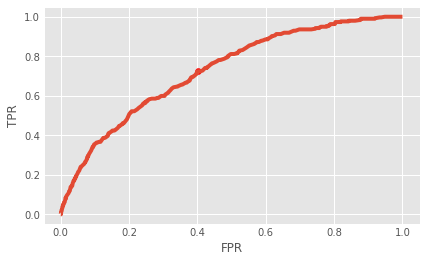

In [488]:
# plot the roc curve and find the threshold which is nearest to the left-top of the ROC curve
fpr,tpr,thresholds=roc_curve(yvalid,yvalid_probas)

gmeans=np.sqrt(tpr*(1-fpr))
i_max=np.argmax(gmeans)

plt.plot(fpr,tpr)
plt.scatter(fpr[i_max],tpr[i_max],marker='o',color='red',label='Best Threshold')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [505]:
best_threshold = thresholds[i_max]
print('Best Threshold: {:.3f}'.format(thresholds[i_max]))

Best Threshold: 0.146


According to the above the roc-auc curve, I decide to choose a threshold which makes TPR at about 0.73 and FPR will be about 0.4.

In [506]:
def adjust_predict(matrix):
    y_probas = gbt.predict(matrix, ntree_limit=n_best_trees)
    return (y_probas > best_threshold).astype(int)

In [507]:
ytest_pred = adjust_predict(test_matrix)

print (classification_report(ytest,ytest_pred))

              precision    recall  f1-score   support

           0       0.99      0.61      0.75     32301
           1       0.04      0.74      0.07       699

    accuracy                           0.61     33000
   macro avg       0.51      0.67      0.41     33000
weighted avg       0.97      0.61      0.74     33000



In [508]:
print ("test precision: {:.2f}%".format(precision_score(ytest,ytest_pred) * 100))
print ("test recall: {:.2f}%".format(recall_score(ytest,ytest_pred) * 100))

test precision: 3.88%
test recall: 73.68%


In [509]:
gbt.save_model('gbt.model')

<a id='question3(1)'></a>
## Question 3
How much do you think your model would improve click through rate? 

I just built a Gradient Boosting Tree model in previous section which predicts whether a user will click the link or not. The new email campaign strategy will only send email to uses which my model predicts positive.

In [510]:
old_emails_sent = ytest_pred.shape[0]
new_email_sent = ytest_pred.sum()
saving_percentage = 100 - new_email_sent * 100.0/old_emails_sent

print('Previous emails sent: {:.2f} '.format(old_emails_sent))
print('New emails sent: {:.2f} '.format(new_email_sent))
print('Saving percentage: {:.2f} '.format(saving_percentage))

Previous emails sent: 33000.00 
New emails sent: 13263.00 
Saving percentage: 59.81 


According to the predictive result on test set:
- 3.88 % of the receivers will open email and click the link. By compared with old strategy, whose click rate is 2.12%, my new strategy can increase the click rate by 1.8 times 

- my model saved nearly 60 % amount, and only need to 30 % of the old email amount

<a id='question4)'></a>
## Question 4
How to test if the model can improve click through rate?

A/B test can be performed totest if the model can improve click through rate:
1. Randomly assign users to two groups, control and experimental group.
2. In control group,user still use the old email-campaign strategy,i.e.,just send emails to users randomly.
3. In experiment group,use the model I built to predict whether the user will click the link or not, and only send emails to those users whose predictive result is positive.
4. Perform a one tail t-test/z-test to test whether experiment group's population proportion is higher than control groups's.